In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import csv

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

%matplotlib inline
%load_ext autoreload

### Set style for plots

In [2]:
sns.set(style="ticks")
sns.set_style("darkgrid")

### Read data from excel

In [3]:
df = pd.read_excel('combat_losses.xlsx', engine='openpyxl')
df = df.set_index('date')

### Quick look at data

In [4]:
df.tail()

,personnel,tanks,APV,artillery systems,MLRS,anti-aircraft warfare systems,aircraft,helicopters,vehicles,boats / cutters,fuel tanks,UAV operational-tactical level,special equipment,mobile SRBM system
date,,,,,,,,,,,,,,
2022-04-12,19600,732,1946,349,111,63,157,140,1406,7,76,124,25,4
2022-04-13,19800,739,1964,358,115,64,158,143,1429,7,76,132,25,4
2022-04-14,19900,753,1968,366,122,64,160,144,1437,7,76,134,25,4
2022-04-15,20000,756,1976,366,122,66,163,144,1443,8,76,135,25,4
2022-04-16,20100,762,1982,371,125,66,163,145,1458,8,76,138,26,4


In [5]:
df.columns

Index(['personnel', 'tanks', 'APV', 'artillery systems', 'MLRS',
       'anti-aircraft warfare systems', 'aircraft', 'helicopters', 'vehicles',
       'boats / cutters', 'fuel tanks', 'UAV operational-tactical level',
       'special equipment', 'mobile SRBM system'],
      dtype='object')

In [6]:
df.describe()

,tanks,APV,artillery systems,MLRS,anti-aircraft warfare systems,aircraft,helicopters,vehicles,boats / cutters,fuel tanks,UAV operational-tactical level,special equipment,mobile SRBM system
count,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000
mean,474.346154,1414.269231,221.192308,75.153846,39.596154,95.865385,99.788462,879.442308,4.480769,65.038462,49.057692,12.576923,1.653846
std,207.442020,482.226947,113.226831,33.550304,19.495861,49.807090,43.216889,446.252519,2.413121,13.854937,47.670196,10.912030,1.969220
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,313.500000,1061.500000,120.000000,56.000000,27.750000,48.750000,80.750000,480.000000,3.000000,60.000000,7.000000,0.000000,0.000000
50%,503.500000,1545.500000,246.000000,80.000000,45.000000,98.000000,122.000000,984.500000,3.000000,65.000000,29.500000,14.000000,0.000000
75%,644.750000,1833.500000,326.250000,105.500000,54.000000,144.000000,134.000000,1255.000000,7.000000,76.000000,89.750000,24.250000,4.000000
max,762.000000,1982.000000,371.000000,125.000000,66.000000,163.000000,145.000000,1458.000000,8.000000,76.000000,138.000000,26.000000,4.000000


### Define functions to handle data approximation
As we see, we have approximate data in personnel losses such as 'less than' or 'more than'.

To handle it we use average losses between 2 war days.

In [7]:
def handle_error(el):
    if str(el)[-1] == '+':
        return 1
    elif str(el)[-1] == '-':
        return -1
    
    return 0

def remove_sign(el):
    if str(el)[-1] in ['+', '-']:
        return int(str(el)[:-1])
    
    return int(el)

def find_error(df):
    n = len(df)

    for i in range(n):
        if df.iloc[i, 0] != remove_sign(df.iloc[i, 0]):
            df.iloc[i, 0] = remove_sign(df.iloc[i, 0]) + handle_error(df.iloc[i, 0]) * ((remove_sign(df.iloc[i+1, 0]) - remove_sign(df.iloc[i, 0])) // 2)


In [8]:
find_error(df)
df = df.fillna(0)
df = df.astype(int)
df.tail()

,personnel,tanks,APV,artillery systems,MLRS,anti-aircraft warfare systems,aircraft,helicopters,vehicles,boats / cutters,fuel tanks,UAV operational-tactical level,special equipment,mobile SRBM system
date,,,,,,,,,,,,,,
2022-04-12,19600,732,1946,349,111,63,157,140,1406,7,76,124,25,4
2022-04-13,19800,739,1964,358,115,64,158,143,1429,7,76,132,25,4
2022-04-14,19900,753,1968,366,122,64,160,144,1437,7,76,134,25,4
2022-04-15,20000,756,1976,366,122,66,163,144,1443,8,76,135,25,4
2022-04-16,20100,762,1982,371,125,66,163,145,1458,8,76,138,26,4


### Daily losses
Let's construct a data frame with daily, not total, losses.

In [9]:
daily_df = pd.DataFrame()

daily_df['date'] = df.index
daily_df = daily_df.set_index('date')
daily_df = df.diff().iloc[:, :].fillna(0).astype(int)

### Quick look at daily losses

In [10]:
daily_df.tail()

,personnel,tanks,APV,artillery systems,MLRS,anti-aircraft warfare systems,aircraft,helicopters,vehicles,boats / cutters,fuel tanks,UAV operational-tactical level,special equipment,mobile SRBM system
date,,,,,,,,,,,,,,
2022-04-12,100,7,23,2,0,8,3,3,19,0,0,5,0,0
2022-04-13,200,7,18,9,4,1,1,3,23,0,0,8,0,0
2022-04-14,100,14,4,8,7,0,2,1,8,0,0,2,0,0
2022-04-15,100,3,8,0,0,2,3,0,6,1,0,1,0,0
2022-04-16,100,6,6,5,3,0,0,1,15,0,0,3,1,0


In [11]:
daily_df.describe()

,personnel,tanks,APV,artillery systems,MLRS,anti-aircraft warfare systems,aircraft,helicopters,vehicles,boats / cutters,fuel tanks,UAV operational-tactical level,special equipment,mobile SRBM system
count,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000
mean,386.538462,14.653846,38.115385,7.134615,2.403846,1.269231,3.134615,2.788462,28.038462,0.153846,1.461538,2.653846,0.500000,0.076923
std,441.156611,12.736984,61.480000,9.246152,3.663597,1.837682,3.236004,4.050352,42.000449,0.459523,5.939108,3.412116,1.475287,0.388368
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,100.000000,7.000000,14.000000,1.750000,0.000000,0.000000,1.000000,0.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,200.000000,12.500000,22.000000,5.000000,1.000000,1.000000,2.000000,1.500000,19.000000,0.000000,0.000000,2.000000,0.000000,0.000000
75%,500.000000,16.250000,37.250000,9.250000,3.250000,2.000000,4.000000,3.000000,31.250000,0.000000,0.000000,3.000000,0.250000,0.000000
max,2200.000000,72.000000,410.000000,49.000000,17.000000,8.000000,16.000000,20.000000,261.000000,2.000000,30.000000,15.000000,10.000000,2.000000


In [12]:
ua_columns = ['особовий склад', 'танки', 'бойові броньовані машини', 'артилерійські системи', 'РСЗВ', 'засоби ППО', 'літаки', 'гелікоптери', 'автомобільна техніка', 'кораблі / катери', 'цистерни з ПММ', 'БПЛА оперативно тактичного рівня', 'спеціальна техніка', 'пускові установки ОТРК / ТРК']

ua_translate = {
    col_en: col_ua for col_en, col_ua in zip(daily_df.iloc[-1, :].index, ua_columns)
}

In [13]:

msg = '**Втрати ворога за добу**🇺🇦💪🏻\n\n'

for i, col in enumerate(daily_df.iloc[-1, :].index):
    msg += f'🔹**{ua_translate[col]}**: {daily_df.iloc[-1, i]}\n'

msg += 38*'-' + '\n**Daily losses of enemies**🇺🇦💪🏻\n\n'

for i, col in enumerate(daily_df.iloc[-1, :].index):
    msg += f'🔸**{col}**: {daily_df.iloc[-1, i]}\n'

print(msg)

**Втрати ворога за добу**🇺🇦💪🏻

🔹**особовий склад**: 100
🔹**танки**: 6
🔹**бойові броньовані машини**: 6
🔹**артилерійські системи**: 5
🔹**РСЗВ**: 3
🔹**засоби ППО**: 0
🔹**літаки**: 0
🔹**гелікоптери**: 1
🔹**автомобільна техніка**: 15
🔹**кораблі / катери**: 0
🔹**цистерни з ПММ**: 0
🔹**БПЛА оперативно тактичного рівня**: 3
🔹**спеціальна техніка**: 1
🔹**пускові установки ОТРК / ТРК**: 0
--------------------------------------
**Daily losses of enemies**🇺🇦💪🏻

🔸**personnel**: 100
🔸**tanks**: 6
🔸**APV**: 6
🔸**artillery systems**: 5
🔸**MLRS**: 3
🔸**anti-aircraft warfare systems**: 0
🔸**aircraft**: 0
🔸**helicopters**: 1
🔸**vehicles**: 15
🔸**boats / cutters**: 0
🔸**fuel tanks**: 0
🔸**UAV operational-tactical level**: 3
🔸**special equipment**: 1
🔸**mobile SRBM system**: 0



### Plot data frames
Here we define a function to plot the whole data.

We should put a data frame, size, columns window and benchmark as parameters to tell whether it is Daily or Total df.

In [14]:
x_ticks = list(map(lambda el: str(el).split()[0], list(df.index)))

def draw(df, height, width, end, mark):
    fig, axs = plt.subplots(height, width)

    columns = iter(df.columns[:end])

    for i in range(3):
        for j in range(4):
            col = next(columns)
            axs[i, j].plot(x_ticks, df[col]);
            axs[i, j].set_xticklabels(x_ticks, rotation=60);
            axs[i, j].set_title(f'{mark} War losses of {col}');
        
    for col, ax in zip(df.columns, axs.flat):
        ax.set(ylabel=col);

    fig.set_figheight(40);
    fig.set_figwidth(40);

    plt.tight_layout()

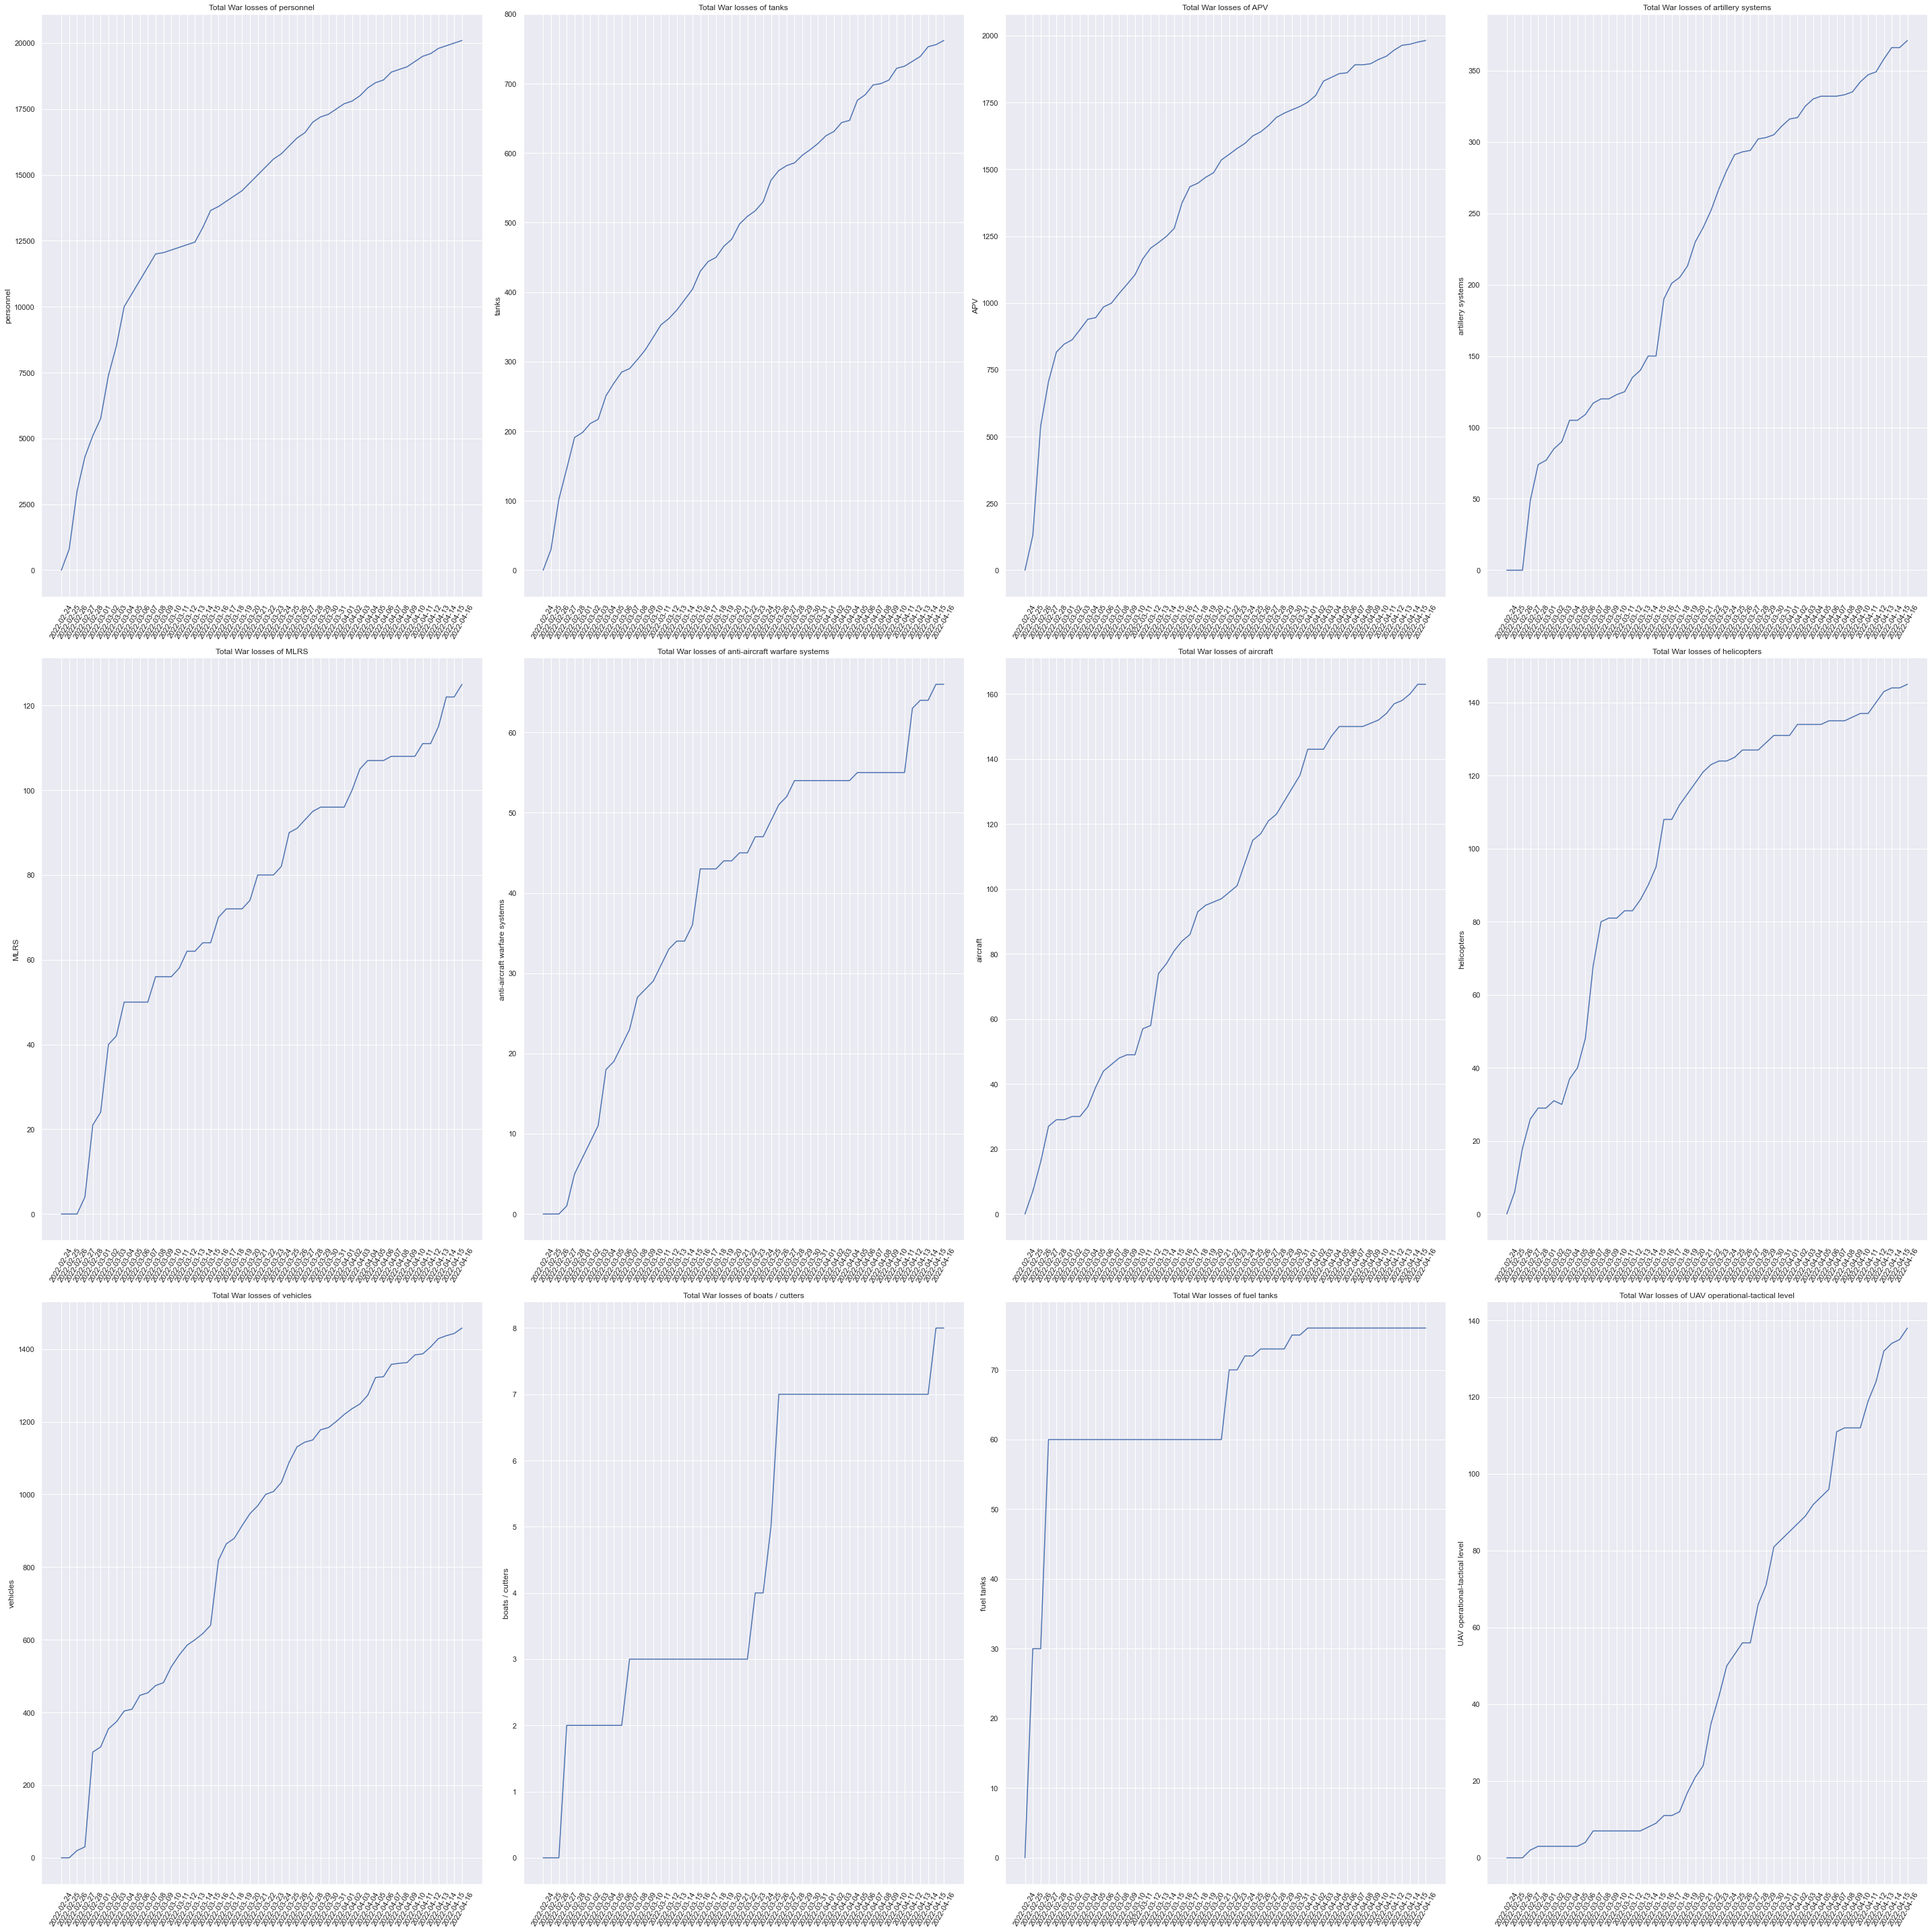

In [15]:
draw(df, 3, 4, len(df)-1, 'Total')

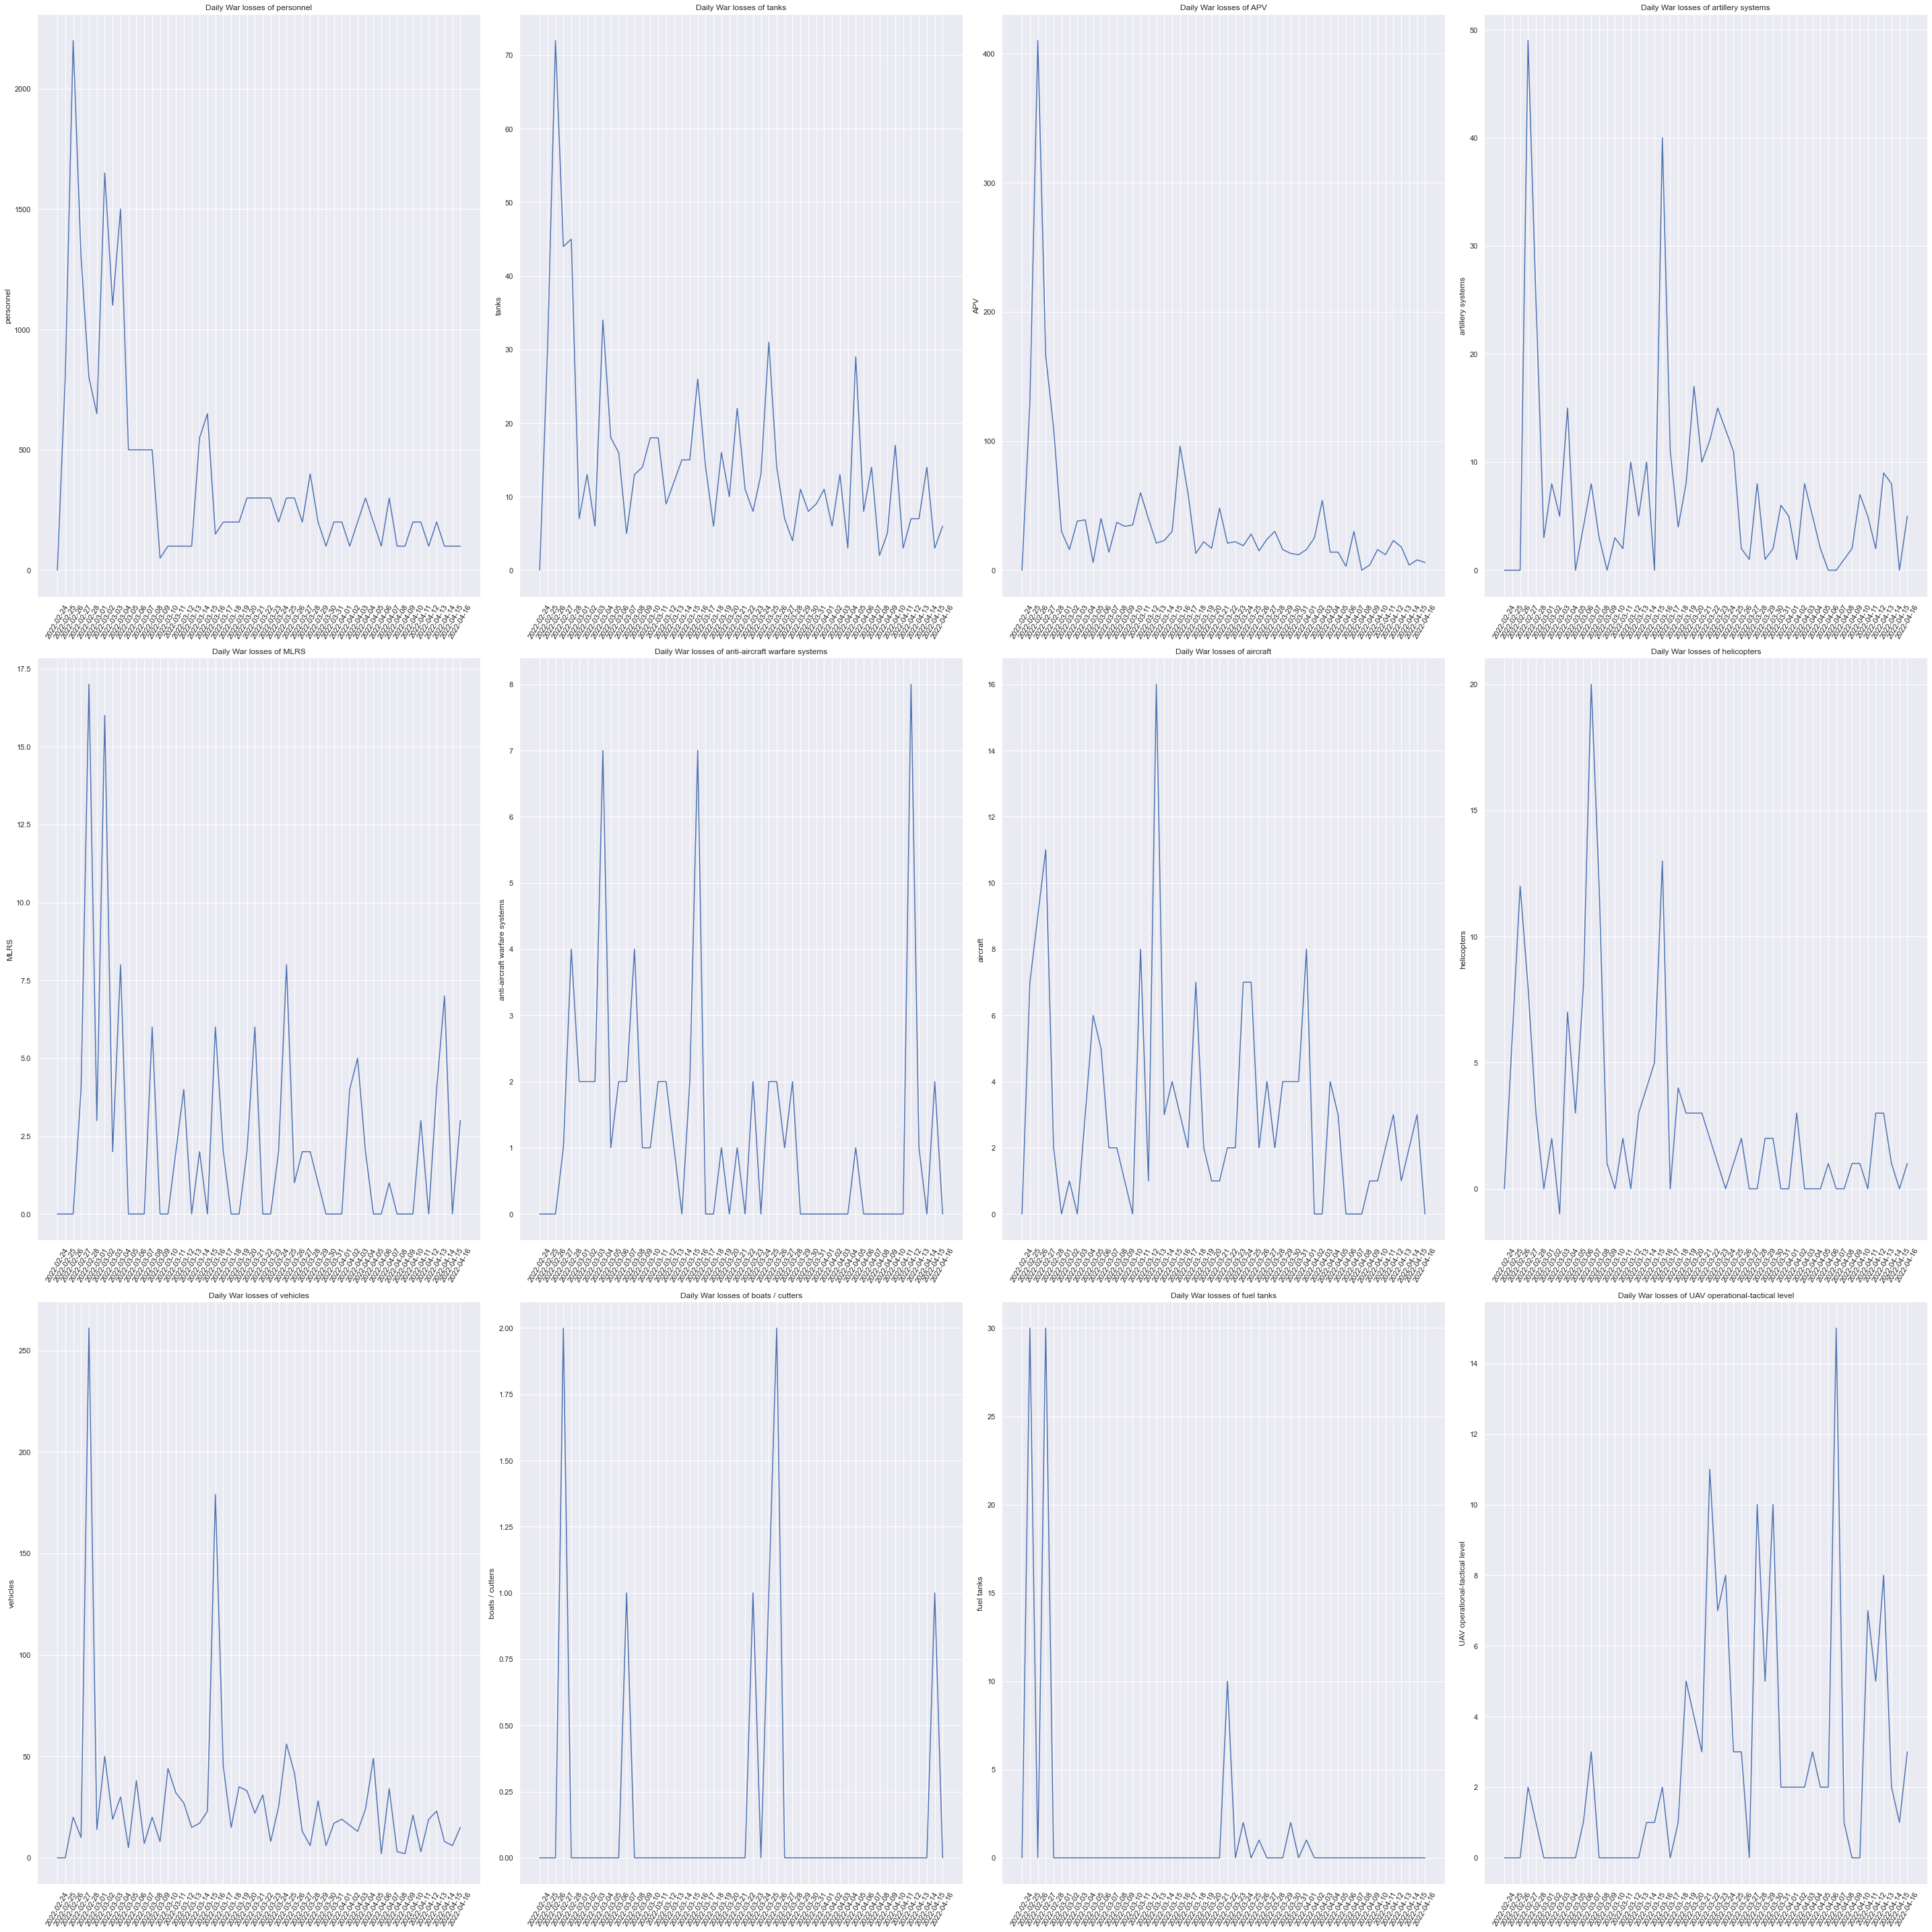

In [16]:
draw(daily_df, 3, 4, len(daily_df)-1, 'Daily')

### Boxplot
Let's take a look at boxplots of daily losses.

As we see, the scale of features is different and it is quite hard to describe each feature on 1 plot.

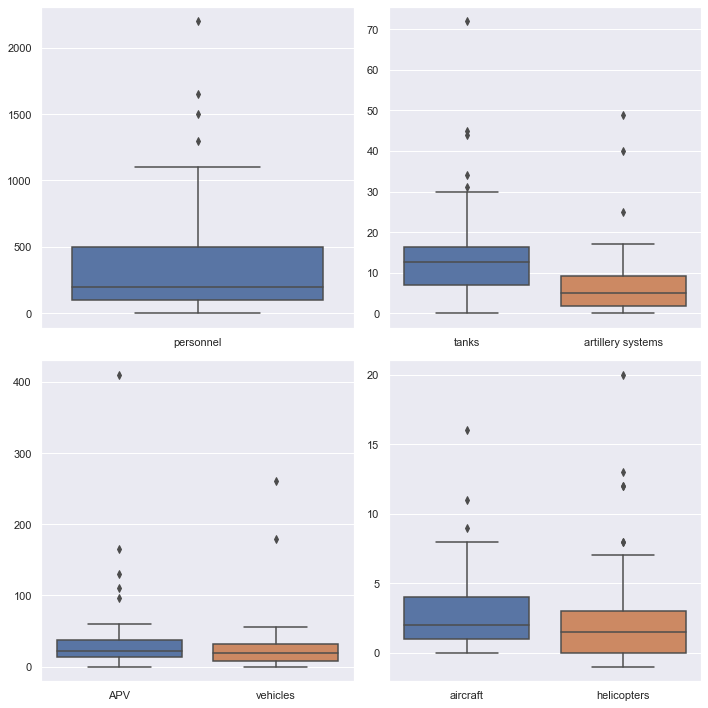

In [17]:
fig, axs = plt.subplots(2, 2)

sns.boxplot(data=daily_df.iloc[:, :1], ax=axs[0, 0])
sns.boxplot(data=daily_df.iloc[:, [1, 3]], ax=axs[0, 1])
sns.boxplot(data=daily_df.iloc[:, [2, 8]], ax=axs[1, 0])
sns.boxplot(data=daily_df.iloc[:, 6:8], ax=axs[1, 1])

fig.set_figheight(10);
fig.set_figwidth(10);

plt.tight_layout()

### Heatmap
Let's take a look at correlation between different losses

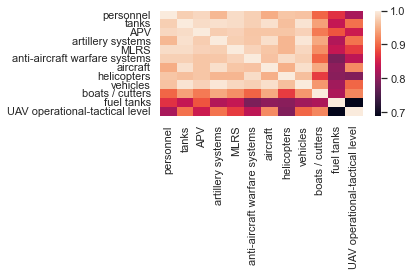

In [18]:
sns.heatmap(df.iloc[:, :-2].corr())
plt.tight_layout()

### War duration (in hours)

In [19]:
war_duration_hours = round((pd.to_datetime('today') - df.index[0]) / pd.Timedelta(hours=1), 2)

print(f'War is going on {len(df)} days ({war_duration_hours} hours)')

War is going on 52 days (1238.39 hours)


### Feature creation
We create feature as range of real numbers instead of date to predict total losses till the given day.

In [20]:
df = df.dropna()

X_log = np.array([np.arange(1, len(df) + 1), np.log(np.arange(1, len(df) + 1))]).T
X = np.array([np.arange(1, len(df) + 1)]).T
y = df[['personnel']]

### Logarithmic Regression
Here we use obtained features to construct Logarithmic model for prediction of the total deaths of russian troops.

As we have few data, it is hard to evaluate our model right now.

In [21]:
log = LinearRegression().fit(X_log, y)

### Linear Regression
Let's apply linear model to our data as well.

In [22]:
lm = LinearRegression().fit(X, y)

### Polynomial Regression
Here it is polynomial regression of degree 3.

In [23]:
polynomial_regression = make_pipeline(PolynomialFeatures(degree=3, include_bias=False), LinearRegression())
polynomial_regression.fit(X, y)

Pipeline(steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=3, include_bias=False)),
                ('linearregression', LinearRegression())])

### Prediction curve
Let's define some functions to handle predictions and plot it.

We will plot both prediction lines and scatter of real data to compare.

In [24]:
def predict_deaths(model, model_name, start, end):
    features = [i for i in range(start, end+1)]

    if model_name == 'Logarithmic Regression':
        X = np.array(list(zip(features, np.log(features))))
    else:
        X = [[i] for i in range(start, end+1)]

    y_hat = model.predict(X)
    y_hat[0] = max(0, y_hat[0])

    return features, y_hat

def predicted_curves(features, predicted, model_name):
    plt.figure(figsize=(7, 5))

    plt.plot(features[:min(len(y), len(features))], y[:min(len(y), len(features))], 'o', ms=4, label = 'Real Deaths')
    plt.plot(features, predicted, label = 'Predicted Deaths')

    plt.xlabel('day index');
    plt.ylabel('deaths');

    plt.title(f'Real vs Predicted Deaths using {model_name}');
    plt.legend();

    plt.tight_layout()

### Models comparing
Comparing models highlighted above, we may observe that Logarithmic Regression is the best estimate of our population, because predictions looks more realistic. Of course, when we get enough data, we will be able to evaluate our models, prevent it from overfitting/underfitting and apply parameters tunning to increase some metrics.

In [25]:
num_days = 60

Передбачення загальної кількості **смертності кацапів** на майбутній тиждень🔥

**День 1**: 19798
**День 2**: 19964
**День 3**: 20128
**День 4**: 20291
**День 5**: 20451
**День 6**: 20610
**День 7**: 20768
--------------------------------------
Prediction of total **losses of the enemies** for the following week🔥

**Day 1**: 19798
**Day 2**: 19964
**Day 3**: 20128
**Day 4**: 20291
**Day 5**: 20451
**Day 6**: 20610
**Day 7**: 20768

Передбачення загальної кількості **смертності кацапів** на майбутній тиждень🔥

**День 1**: 21254
**День 2**: 21572
**День 3**: 21891
**День 4**: 22209
**День 5**: 22527
**День 6**: 22846
**День 7**: 23164
--------------------------------------
Prediction of total **losses of the enemies** for the following week🔥

**Day 1**: 21254
**Day 2**: 21572
**Day 3**: 21891
**Day 4**: 22209
**Day 5**: 22527
**Day 6**: 22846
**Day 7**: 23164

Передбачення загальної кількості **смертності кацапів** на майбутній тиждень🔥

**День 1**: 19889
**День 2**: 20220
**День 3**: 205

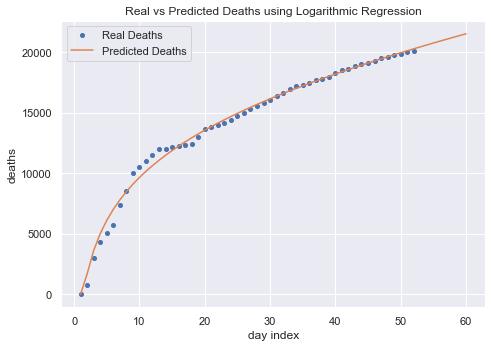

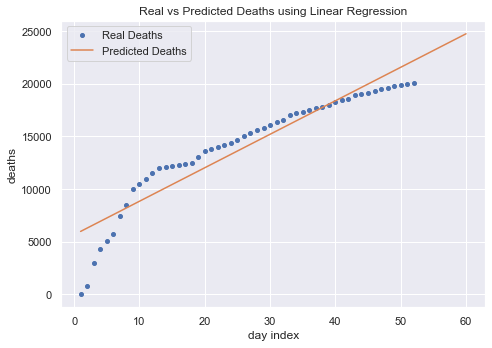

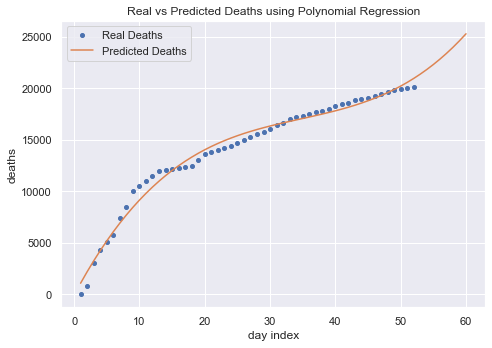

In [26]:
models = {'Logarithmic Regression': log, 'Linear Regression': lm,  'Polynomial Regression': polynomial_regression}

for model_name, model in models.items():
    features, predicted = predict_deaths(model, model_name, 1, num_days)
    predicted_curves(features, predicted, model_name)


### Write obtained results in the csv file

In [27]:
def write_csv(file):
    data = list(zip(X.T[0], np.array(y)))
    data = list(map(lambda el: [int(el[0]), int(el[1])], data))

    features, predicted = predict_deaths(log, 'Logarithmic Regression', data[-1][0]+1, num_days)

    predicted = list(map(int, predicted))
    data.extend(list(map(list, list(zip(features, predicted)))))

    with open(file, 'w') as f:
        write = csv.writer(f)
        write.writerow(['day index', 'deaths'])
        write.writerows(data)

In [28]:
# write_csv('losses.csv')

## Conclusion
Russian troops should become more conscious.They will join to the part of sad statistics otherwise. Ukraine doesn't want to kill, but Ukraine wants to defend it's people. Get away of our country!

Русский военный корабль, иди нах*й
#### Glory to Ukraine!
#### Слава Україні!

## Data source
General Staff of the Armed Forces of Ukraine
 
https://www.facebook.com/GeneralStaff.ua

## Credits
© Mykhailo-Markiian Tsalyk

https://www.linkedin.com/in/markiian-tsalyk-193758224/